In [1]:
__author__ = 'Felix Pat <felixpat10@email.arizona.edu>'
__version__ = '20230609' # yyyymmdd; version datestamp of this notebook
__datasets__ = ['gogreen_dr1']  # datasets used in this notebook
__keywords__ = ['gemini llp','tap','cluster','photometry','redshift','file service','spectra','catalogues'] # keywords relevant to this notebook

# Intro to Spectroscopy from the GOGREEN DR1 Dataset
*Author: Felix Pat (Univ. of Arizona), Stephanie Juneau (NOIRLab), and the Astro Data Lab Team*

### Table of contents
* [Goal](#Specgoal)
* [Summary](#Specsummary)
* [Disclaimer & attribution](#Specdisclaimer)
* [Imports & setup](#Specimport)
* [Define functions used in tutorial](#Spec0)
* [Reading in catalogs from the Data Lab database](#Spec1)
* [Make variables for commonly used pathways](#Spec2)
* [Print pathway of clusters with available 2D galaxy spectra](#Spec3)
* [Make variables for pre-selected galaxy name and specid](#Spec4)
* [Print available url's of selected cluster and display galaxy image](#Spec5)
* [Display 1D and 2D spectrum of galaxy](#Spec6)
* [Find continuum subtracted spectrum and gaussian fit from region of interest](#Spec7)
* [Compare calculated redshift and equivalent width values to GOGREEN](#Spec8)
* [References](#Spec9)

<a class="anchor" id="Specgoal"></a>
# Goal
This notebook aims to illustrate 1D and 2D spectrum emission line features and how to derive the redshift and equivalent width of the \[O II]3727 doublet from a Gaussian fit.

<a class="anchor" id="Specsummary"></a>
# Summary
This notebook demonstrates how to display a galaxy image, plot its 1D and 2D spectrum, and fit the emission line to calculate the redshift and equivalent width to compare to the GOGREEN database values.

<a class="anchor" id="Specsummary"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: https://datalab.noirlab.edu/disclaimers.php

<a class="anchor" id="Specimport"></a>
# Imports and setup

In [2]:
# std lib
from io import BytesIO
import gzip
import re

# 3rd party
import numpy as np
np.seterr(divide='ignore')
import math
import pandas as pd
pd.set_option('display.max_columns', 500) # prevent overflow of columns 
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14 # increase plot texts size
from pyvo.dal import sia
from IPython.display import display_html

from astropy.modeling import models
from astropy.utils.data import download_file
from astropy.wcs import WCS
from astropy.io import fits, ascii
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM

from specutils import Spectrum1D
from specutils.fitting import fit_lines
from specutils import SpectralRegion
from specutils.manipulation import extract_region

from scipy import integrate

# Data Lab
from dl import queryClient as qc, storeClient as sc

In [3]:
# define cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3) 
# this URL tells the SIA service where to find images and image metadata
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/gogreen_dr1"
svc = sia.SIAService(DEF_ACCESS_URL)

<a class="anchor" id="Spec1"></a>
# Reading in main tables
The full GOGREEN dataset can be found [here](https://datalab.noirlab.edu/gogreendr1/index.php) under the 'Data Access' tab. The first portion of this notebook will rely on information available for all clusters from the 'clusters_table' and information for the galaxies from the 'redshift_table.' Since we do not need use all of the photometry/images, we will only retrieve them as needed in the later portion of the notebook. 

We can use the globals() function to dynamically create variables. [Globals()](https://docs.python.org/3/library/functions.html#globals) returns the dictionary implementing the current module namespace. For code within functions, this is set when the function is defined and remains the same regardless of where the function is called.

In [4]:
dataset = 'gogreen_dr1.'
tables = ['clusters', 'redshift']

for table in tables:
    globals()['%s_table'%table] = qc.query('select * from %s%s' % (dataset, table), fmt = 'pandas')
    print('%s'%table)
    display_html(globals()[('%s_table'%table)].head(5))

clusters


,cluster,fullname,cluster_id,ra_best,dec_best,ra_gmos,dec_gmos,pa_deg,redshift,vdisp,vdisp_err,gogreen_m1,gogreen_m2,gogreen_m3,gogreen_m4,gogreen_m5,gogreen_m6,gclass_m1,gclass_m2,gclass_m3,gclass_m4,gclass_m5,kphot_cat,photoz_cat,stelmass_cat,image_u,image_b,image_g,image_v,image_r,image_i,image_z,image_j,image_j1,image_y,image_k,image_irac1,preimage,random_id
0,COSMOS-125,COSMOS-125,14,150.6208,2.1675,150.62720,2.159200,270.0,1.4040,NaN,400,GS2015ALP001-02,GS2016ALP001-02,GS2019ALP001-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UVISTA_final_v4.1_t1.fits,UVISTA_final_v4.1_zout.fits,UVISTA_final_colors_sfrs_v4.1.dat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GMICOSMOS-125_pseudo,82.235855
1,COSMOS-221,COSMOS-221,14,150.5620,2.5031,150.57020,2.498600,90.0,1.1960,200.0,50,GS2014BLP001-05,GS2015ALP001-01,GS2016ALP001-01,GS2019ALP001-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UVISTA_final_v4.1_t1.fits,UVISTA_final_v4.1_zout.fits,UVISTA_final_colors_sfrs_v4.1.dat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GMICOSMOS-221_pseudo,16.224028
2,COSMOS-28,COSMOS-28,14,149.4692,1.6685,149.45930,1.675030,78.0,1.3160,285.0,75,GN2015BLP004-03,GN2019ALP004-01,GN2019ALP004-02,GN2019ALP004-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UVISTA_final_v4.1_t1.fits,UVISTA_final_v4.1_zout.fits,UVISTA_final_colors_sfrs_v4.1.dat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GMICOSMOS-28_pseud,14.708872
3,COSMOS-63,COSMOS-63,14,150.3590,1.9352,150.36147,1.928342,165.0,1.1722,NaN,70,GN2015BLP004-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UVISTA_final_v4.1_t1.fits,UVISTA_final_v4.1_zout.fits,UVISTA_final_colors_sfrs_v4.1.dat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GMICOSMOS-63_pseudo,10.737590
4,SPT0205,SPT-CL J0205-5829,1,31.4510,-58.4803,31.43896,-58.482900,90.0,1.3227,678.0,57,GS2014BLP001-06,GS2016BLP001-09,GS2016BLP001-02,GS2017BLP001-03,GS2017BLP001-04,GS2017BDD010-01,NaN,NaN,NaN,NaN,NaN,SPTCL-0205_totalall_FOURSTARKs.cat,SPTCL-0205_totalall_Ks.zout,SPTCL-0205_totalall_Ks.fout,mos_VIMOSU_3,mos_VIMOSB_3,NaN,mos_VIMOSV_3,mos_VIMOSR_3,mos_VIMOSI_3,mos_VIMOSz_3,mos_FOURSTARJ_3,mos_FOURSTARJ1_3,NaN,mos_FOURSTARKs_3,mos_IRAC1_3,mfrgS20140928S0161_add,73.878470


redshift


,cluster,specid,ra,dec,objclass,redshift,redshift_quality,extver,spec_flag,snr_8500_var,snr_8500_rms,d4000,ed4000,ewoii,eewoii,ewhdelta,eewhdelta,ewoii_model,eewoii_model,f_oii,ef_oii,sfr_oii,esfr_oii,delta_bic,member_clean,member_em,member,htm9,ring256,nest4096,random_id
0,COSMOS-125,114080478,150.60518,2.118631,1,1.41478,2,1,0,2.855579,1.827386,NaN,NaN,NaN,NaN,NaN,NaN,4.155094,1.096318,0.0,0.0,3.228765,0.796476,7.636033,-1,-1,-1,3709735,378796,111644063,59.368240
1,COSMOS-125,114080570,150.59448,2.120006,1,1.34553,4,2,0,3.217247,2.300130,1.364112,0.076498,11.551618,4.967136,5.405303,4.758426,11.549834,1.890590,0.0,0.0,4.880185,0.753583,71.387190,-1,-1,-1,3709735,378796,111644063,63.859104
2,COSMOS-125,114081196,150.58768,2.128183,3,0.96172,4,3,0,10.048548,7.505558,1.206696,0.030443,3.372206,1.760464,3.249191,1.707648,4.091792,0.768290,0.0,0.0,3.261066,0.575365,25.215458,-1,-1,-1,3709735,378796,111644085,28.451246
3,COSMOS-125,114081258,150.59691,2.129453,1,0.72447,3,4,0,4.754746,3.284939,1.433353,0.130532,1.186794,38.480305,-1.591362,6.184247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,-1,3709735,378796,111644085,75.506805
4,COSMOS-125,114081508,150.60970,2.134149,1,1.13177,4,5,0,2.862871,1.829309,1.294710,0.089390,67.153460,35.867435,2.344702,5.377402,42.830364,3.741641,0.0,0.0,5.096052,0.379176,297.244870,-1,-1,-1,3709735,378796,111644106,52.536415


<a class="anchor" id="Spec2"></a>
# Make variables for commonly used pathways
To have a centralized dataset, a combined [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) is made by matching the galaxies in the redshift_table to the clusters in the clusters_table.

In [5]:
oneddir = 'gogreen_dr1://SPECTROSCOPY/OneD/'  # 1-d spectra
twoddir = 'gogreen_dr1://SPECTROSCOPY/TwoD/'  # 2-d spectra
imdir = 'gogreen_dr1://PHOTOMETRY/IMAGES/'    # photometry and images

#make merged table of cluster and redshift
merge_col = ['cluster']

# Here attach suffix _c to distinguish between galaxy values (Redshift) and cluster values (Redshift_c)
matched_table = pd.merge(redshift_table, clusters_table, how='left', \
                         left_on=merge_col, right_on=merge_col, suffixes=['','_c'] )
matched_table.head(5)

,cluster,specid,ra,dec,objclass,redshift,redshift_quality,extver,spec_flag,snr_8500_var,snr_8500_rms,d4000,ed4000,ewoii,eewoii,ewhdelta,eewhdelta,ewoii_model,eewoii_model,f_oii,ef_oii,sfr_oii,esfr_oii,delta_bic,member_clean,member_em,member,htm9,ring256,nest4096,random_id,fullname,cluster_id,ra_best,dec_best,ra_gmos,dec_gmos,pa_deg,redshift_c,vdisp,vdisp_err,gogreen_m1,gogreen_m2,gogreen_m3,gogreen_m4,gogreen_m5,gogreen_m6,gclass_m1,gclass_m2,gclass_m3,gclass_m4,gclass_m5,kphot_cat,photoz_cat,stelmass_cat,image_u,image_b,image_g,image_v,image_r,image_i,image_z,image_j,image_j1,image_y,image_k,image_irac1,preimage,random_id_c
0,COSMOS-125,114080478,150.60518,2.118631,1,1.41478,2,1,0,2.855579,1.827386,NaN,NaN,NaN,NaN,NaN,NaN,4.155094,1.096318,0.0,0.0,3.228765,0.796476,7.636033,-1,-1,-1,3709735,378796,111644063,59.368240,COSMOS-125,14,150.6208,2.1675,150.6272,2.1592,270.0,1.404,NaN,400,GS2015ALP001-02,GS2016ALP001-02,GS2019ALP001-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UVISTA_final_v4.1_t1.fits,UVISTA_final_v4.1_zout.fits,UVISTA_final_colors_sfrs_v4.1.dat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GMICOSMOS-125_pseudo,82.235855
1,COSMOS-125,114080570,150.59448,2.120006,1,1.34553,4,2,0,3.217247,2.300130,1.364112,0.076498,11.551618,4.967136,5.405303,4.758426,11.549834,1.890590,0.0,0.0,4.880185,0.753583,71.387190,-1,-1,-1,3709735,378796,111644063,63.859104,COSMOS-125,14,150.6208,2.1675,150.6272,2.1592,270.0,1.404,NaN,400,GS2015ALP001-02,GS2016ALP001-02,GS2019ALP001-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UVISTA_final_v4.1_t1.fits,UVISTA_final_v4.1_zout.fits,UVISTA_final_colors_sfrs_v4.1.dat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GMICOSMOS-125_pseudo,82.235855
2,COSMOS-125,114081196,150.58768,2.128183,3,0.96172,4,3,0,10.048548,7.505558,1.206696,0.030443,3.372206,1.760464,3.249191,1.707648,4.091792,0.768290,0.0,0.0,3.261066,0.575365,25.215458,-1,-1,-1,3709735,378796,111644085,28.451246,COSMOS-125,14,150.6208,2.1675,150.6272,2.1592,270.0,1.404,NaN,400,GS2015ALP001-02,GS2016ALP001-02,GS2019ALP001-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UVISTA_final_v4.1_t1.fits,UVISTA_final_v4.1_zout.fits,UVISTA_final_colors_sfrs_v4.1.dat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GMICOSMOS-125_pseudo,82.235855
3,COSMOS-125,114081258,150.59691,2.129453,1,0.72447,3,4,0,4.754746,3.284939,1.433353,0.130532,1.186794,38.480305,-1.591362,6.184247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,-1,3709735,378796,111644085,75.506805,COSMOS-125,14,150.6208,2.1675,150.6272,2.1592,270.0,1.404,NaN,400,GS2015ALP001-02,GS2016ALP001-02,GS2019ALP001-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UVISTA_final_v4.1_t1.fits,UVISTA_final_v4.1_zout.fits,UVISTA_final_colors_sfrs_v4.1.dat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GMICOSMOS-125_pseudo,82.235855
4,COSMOS-125,114081508,150.60970,2.134149,1,1.13177,4,5,0,2.862871,1.829309,1.294710,0.089390,67.153460,35.867435,2.344702,5.377402,42.830364,3.741641,0.0,0.0,5.096052,0.379176,297.244870,-1,-1,-1,3709735,378796,111644106,52.536415,COSMOS-125,14,150.6208,2.1675,150.6272,2.1592,270.0,1.404,NaN,400,GS2015ALP001-02,GS2016ALP001-02,GS2019ALP001-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UVISTA_final_v4.1_t1.fits,UVISTA_final_v4.1_zout.fits,UVISTA_final_colors_sfrs_v4.1.dat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GMICOSMOS-125_pseudo,82.235855


<a class="anchor" id="Spec3"></a>
# Print clusters with available 2D galaxy spectra
As described by Balogh et al. (2021), 2D spectra are only available for [GOGREEN spectra and not for GCLASS spectra.](https://datalab.noirlab.edu/gogreendr1/index.php) So we print the list of files with available 2D spectra to select an example cluster.

In [6]:
print(sc.ls(twoddir,format='long'))

-rw-rw-r-x  gogreen_dr1  8714082  13 Aug 2020 17:54  COSMOS-125_twod.fits.gz
-rw-rw-r-x  gogreen_dr1  10620431  13 Aug 2020 17:54  COSMOS-221_twod.fits.gz
-rw-rw-r-x  gogreen_dr1  14009121  13 Aug 2020 17:54  COSMOS-28_twod.fits.gz
-rw-rw-r-x  gogreen_dr1  4838575  13 Aug 2020 17:54  COSMOS-63_twod.fits.gz
-rw-rw-r-x  gogreen_dr1     340  13 Aug 2020 17:54  README
-rw-rw-r-x  gogreen_dr1  11848796  13 Aug 2020 17:54  SPT0205_twod.fits.gz
-rw-rw-r-x  gogreen_dr1  15034157  13 Aug 2020 17:54  SPT0546_twod.fits.gz
-rw-rw-r-x  gogreen_dr1  10916915  13 Aug 2020 17:54  SPT2106_twod.fits.gz
-rw-rw-r-x  gogreen_dr1  27405946  13 Aug 2020 17:54  SXDF49_twod.fits.gz
-rw-rw-r-x  gogreen_dr1  3710772  13 Aug 2020 17:54  SXDF64_twod.fits.gz
-rw-rw-r-x  gogreen_dr1  13944087  13 Aug 2020 17:54  SXDF76_twod.fits.gz
-rw-rw-r-x  gogreen_dr1  11352764  13 Aug 2020 17:54  SpARCS0035_twod.fits.gz
-rw-rw-r-x  gogreen_dr1  10195223  13 Aug 2020 17:54  SpARCS0219_twod.fits.gz
-rw-rw-r-x  gogreen_dr1  108790

A similar method can be used to look at the 1D directory which contains the .fits files, and that can be compare to the 2D list above to see which clusters have both 1D and 2D spectrum. The accompanying notebook [0_GOGREENDr1FileService.ipynb](https://github.com/astro-datalab/notebooks-latest/tree/master/03_ScienceExamples/GOGREEN_GalaxiesInRichEnvironments/0_GOGREENDr1FileService.ipynb) gives a tour of the directories in the gogreen_dr1 file system. 

<a class="anchor" id="Spec4"></a>
# Pre-selected example galaxy
A pre-selected cluster and galaxy is called, which can be checked in the pathway to their directories.

In [7]:
cluster_name = 'SpARCS1616'
galaxy_specid = 110000760  # galaxy that is part of the cluster
name_bool = clusters_table.cluster==cluster_name
index_num = clusters_table.cluster[name_bool].index[0]

<a class="anchor" id="Spec5"></a>
# List available images from the SIA service
The first step is to identify a specific cluster and a galaxy within cluster.
Then, we use the resulting table to request from the SIA service small cutouts (FOV = 0.005 degrees) around the RA & Dec coordinates. In the SIA service, images with filters or types as weight, mask, or wht are excluded.

In [8]:
matched_galaxy = matched_table[(matched_table.specid==galaxy_specid)&(matched_table.cluster==cluster_name)]
matched_galaxy

,cluster,specid,ra,dec,objclass,redshift,redshift_quality,extver,spec_flag,snr_8500_var,snr_8500_rms,d4000,ed4000,ewoii,eewoii,ewhdelta,eewhdelta,ewoii_model,eewoii_model,f_oii,ef_oii,sfr_oii,esfr_oii,delta_bic,member_clean,member_em,member,htm9,ring256,nest4096,random_id,fullname,cluster_id,ra_best,dec_best,ra_gmos,dec_gmos,pa_deg,redshift_c,vdisp,vdisp_err,gogreen_m1,gogreen_m2,gogreen_m3,gogreen_m4,gogreen_m5,gogreen_m6,gclass_m1,gclass_m2,gclass_m3,gclass_m4,gclass_m5,kphot_cat,photoz_cat,stelmass_cat,image_u,image_b,image_g,image_v,image_r,image_i,image_z,image_j,image_j1,image_y,image_k,image_irac1,preimage,random_id_c
1458,SpARCS1616,110000760,244.19926,55.714027,1,0.93372,4,1,0,7.455099,4.035182,1.164522,0.040819,0.0,0.0,0.0,0.0,50.33022,1.101667,0.0,0.0,2.362466,0.03426,6381.294,0,0,0,3515739,67843,41608456,6.687962,SpARCS J1616+5545,10,244.1722,55.7534,244.1718,55.757139,0.0,1.156,782.0,39,GN2016ALP004-06,GN2016ALP004-07,GN2017ALP004-09,GN2018ALP004-08,NaN,NaN,GN2009AQ001-01,GN2009AQ001-02,GN2009AQ001-03,GN2010AQ00-06,GN2010AQ001-07,SpARCS-1616_totalall_WIRCamK.cat,SpARCS-1616_totalall_Ks.zout,SpARCS-1616_totalall_Ks.fout,mos_MegaCamu_3,NaN,mos_Suprimeg_3,NaN,mos_Suprimer_3,mos_Suprimei_3,mos_HSCz_3,mos_WIRCamJ_3,NaN,mos_HSCy_3,mos_WIRCamK_3,mos_IRAC1_3,mfrgN20150514S0083_add,23.316412


In [9]:
def choose_image(matched_galaxy):
    """
    Return a table of the selected cluster image urls with its position (RA, Dec).

    Parameters
    ----------
    matched_galaxy : pandas dataframe
    Data table of selected galaxy

    Returns
    -------
    row : pandas dataframe
    Data table for image urls of selected galaxy
    
    ra : float
    RA of selected galaxy
    
    dec : float
    Dec of selected galaxy
    """
    fov = 0.005 # degrees (= 18 arcsec)
    ra, dec = matched_galaxy.ra, matched_galaxy.dec
    
    # simply passing the argument %.4f rounds the number at the 4th decimal place, 
    # which will raise an error if it rounds up and goes out of bounds of the image itself
    
    ra = math.floor(matched_galaxy.ra * 10 ** 4) / 10 ** 4 # take first four decimal place without rounding for RA
    dec = math.floor(matched_galaxy.dec * 10 ** 4) / 10 ** 4 # take first four decimal place without rounding for DEC
    print("RA = %.4f, DEC = %.4f" %(ra, dec))
    imgTable = svc.search((ra,dec), (fov, fov), verbosity=2).to_table().to_pandas()

    split_selection = re.split('(\d+)',matched_galaxy['cluster'].to_string()) # words [2], numbers [3]
    include_url = [split_selection[2].lower().strip(), split_selection[3], \
                    str(math.floor(matched_galaxy.ra * 10 ** 4) / 10 ** 4), str(math.floor(matched_galaxy.dec * 10 ** 4) / 10 ** 4)]
    exclude_url = ['weight','mask','wht']
    
    # make new pandas dataframe for image urls that pass all conditions
    row = pd.DataFrame()
    for i in range(np.nanmax(imgTable.index)+1):
        if all(include_string_in_url in imgTable.access_url[i].lower() for include_string_in_url in include_url) \
        and all(exclude_word_in_url not in imgTable.access_url[i].lower() for exclude_word_in_url in exclude_url):

            data = (imgTable.iloc[[i],:])
            row = pd.concat((row,data))
        
    print("Available indices to choose from:")
    print(row.index)
    for i in range(np.nanmax(row.index)+1):
        if i not in row.index:
            continue
        else:
            full_url = row.access_url[i]
            short_url = full_url.split(sep='&')[1]
            print(i, short_url)

    return (row, ra, dec)

In [10]:
row, ra, dec = choose_image(matched_galaxy)

RA = 244.1992, DEC = 55.7140
Available indices to choose from:
Int64Index([ 0,  4,  6,  8, 10, 11, 13, 15, 17, 19, 21, 24, 26, 28, 30, 32, 34,
            36, 38, 40, 42, 44, 46, 48, 50],
           dtype='int64')
0 siaRef=images/SpARCS-1616/mos_IRAC4.psf2_3.fits
4 siaRef=images/SpARCS-1616/mos_HSCy.psf_3.fits
6 siaRef=images/SpARCS-1616/mos_HSCy_3.fits
8 siaRef=images/SpARCS-1616/mos_HSCz.psf_3.fits
10 siaRef=images/SpARCS-1616/mos_HSCz_3.fits
11 siaRef=images/SpARCS-1616/mos_IRAC1.psf2_3.fits
13 siaRef=images/SpARCS-1616/mos_IRAC1_3.fits
15 siaRef=images/SpARCS-1616/mos_IRAC2.psf2_3.fits
17 siaRef=images/SpARCS-1616/mos_IRAC2_3.fits
19 siaRef=images/SpARCS-1616/mos_IRAC3.psf2_3.fits
21 siaRef=images/SpARCS-1616/mos_IRAC3_3.fits
24 siaRef=images/SpARCS-1616/mos_IRAC4_3.fits
26 siaRef=images/SpARCS-1616/mos_MegaCamu.psf_3.fits
28 siaRef=images/SpARCS-1616/mos_MegaCamu_3.fits
30 siaRef=images/SpARCS-1616/mos_Suprimeg.psf_3.fits
32 siaRef=images/SpARCS-1616/mos_Suprimeg_3.fits
34 siaRef=

In [11]:
def callSIA(ra,dec,row,selection,galaxy_specid,user_pick_index): 
    """
    Plots the selected processed image of a galaxy cutout using the svc pathway.

    Parameters
    ----------
    ra : float
    RA of selected galaxy
    
    dec : float
    Dec of selected galaxy
    
    row : pandas dataframe
    Data table for image urls of selected galaxy
    
    selection : string
    Name of selected cluster
    
    galaxy_specid : int
    Number to identity specific galaxy
    
    user_pick_index : int
    User's choice of image from the list of available indices above

    Returns
    -------
    None
    """
    # make galaxy image cutouts from full image
    fov = 0.005
    if user_pick_index not in row.index:
        print("Index is not available. Pick from the following indices:")
        print(row.index)
    else:
        row = svc.search((ra,dec), (fov, fov), verbosity=2).to_table() # image cutout
        sel = (row['proctype'] != 'wtmap')
        new_row = row[sel][user_pick_index]
        url = new_row['access_url']
        filename = download_file(url,cache=True,show_progress=False,timeout=120)
        hdu = fits.open(filename)[0]
        image = hdu.data
        wcs = WCS(hdu.header)

        print("image coloring min = %f, max = %f, median = %f" %(np.nanmin(image),np.nanmax(image),np.median(image)))
        fig = plt.figure(figsize=(13,13))
        ax = fig.add_subplot(projection=wcs, label='overlays')
        vrange = np.nanmax(image)-np.nanmin(image)
        
        vbot = np.nanmin(image)-.1*vrange #change percentage as needed (suggest +0.001 for HST; +0.1 for ground-based)
        vtop = np.nanmin(image)+.5*vrange #change percentage as needed (suggest +0.1 for HST; +0.5 for ground-based)
        ax.imshow(np.arcsinh(image),origin='lower',cmap='bone',vmin=np.arcsinh(vbot),vmax=np.arcsinh(vtop))
        ax.set_title("%s cluster %i specid" %(selection,galaxy_specid))

        lon = ax.coords[0]
        lat = ax.coords[1]
        lon.set_major_formatter('d.ddd')
        lat.set_major_formatter('d.ddd')

        ax.grid(color='white', ls='solid')

After seeing all of the available images, pick an index from the list above to plot the processed galaxy image. It is important to note the contrast parameters (vbot, vtop) will need to be adjusted for other images as a guess-and-check until the desired image resolution is met.

image coloring min = -0.380847, max = 2.190058, median = 0.010697


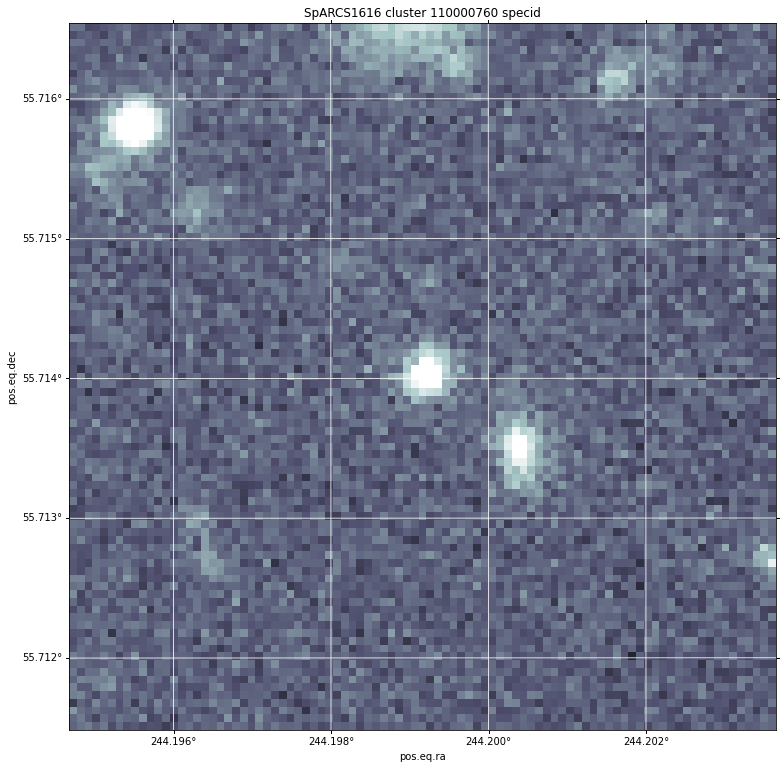

In [12]:
user_pick_index = 10
callSIA(ra, dec, row, cluster_name, galaxy_specid, user_pick_index)

The center galaxy in the image is the selected galaxy, and nearby and far away galaxies are seen as well in this cutout.

<a class="anchor" id="Spec6"></a>
# Full 1D and 2D spectrum of pre-selected galaxy
The wavelength, flux, and variance of the flux is queried from the database using the redshift_table. In this section, the 1D and 2D spectrum are plotted above and below each other to compare the similarities and differences in the emission line expressions. Some of the functionality is similar to the notebook [GOGREEN Data Release 1 data access at Astro Data Lab](https://github.com/astro-datalab/notebooks-latest/blob/master/03_ScienceExamples/GOGREEN_GalaxiesInRichEnvironments/1_GOGREENDr1DataAccessAtDataLab.ipynb).

In [13]:
def get_wavelength_from_hdu(hdr):
    """
    Reads 'CRVAL1' 'NAXIS1' and 'CD1_1' to compute wavelength coverage.

    Parameters
    ----------
    hdr : hdu object
    Fits file table using BytesIO

    Returns
    -------
    None
    """
    return np.arange(hdr['CRVAL1'], hdr['CRVAL1']+hdr['NAXIS1']*hdr['CD1_1'], hdr['CD1_1'])

def get_spectrum(hdu, extver, units='fl', return_frame='observed', redshift=0.):
    """
    Access spectrum from fits file, convert to specified units in rest frame.

    Note: Input spectrum must be in units erg cm^-2 s^-1 A^-1
    Note: Header values must give wavelength in Angstroms

    Parameters
    ----------
    hdr : hdu object
    Fits file table using BytesIO
    
    extver : pandas dataframe
    Redshift_table['extver'] column with galaxy index
    
    units : string
    Units of output spectrum, case insensitive
    
    return_frame : string
    What frame to return the wavelength units in. If 'rest', a redshift is required.
    
    redshift : float
    Redshift of galaxy to convert to rest-frame, if redshift = 0 returns observed-frame

    Returns
    -------
    lam : numpy array of float
    Wavelength in Angstroms
    
    spec : numpy array of float
    Flux in erg cm^-2 s^-1 A^-1
    
    var : numpy array of float
    Variance of flux in erg cm^-2 s^-1 A^-1
    """
    extver = int(extver)

    units = units.lower()
    assert units in ['fl','maggies','fnu'], 'Error, units must be "Fl" or "maggies"'
    return_frame = return_frame.lower()
    assert return_frame in ['rest','observed'], 'Error, return_frame must be either "rest" or "observed"'

    scale = hdu['SCI',extver].header['FLUXSCAL']
    spec = hdu['SCI',extver].data / scale
    var = hdu['VAR',extver].data / scale**2
    lam = get_wavelength_from_hdu(hdu['SCI',extver].header)

    if return_frame == 'rest': # convert from observed to rest wavelength
        assert redshift >= 0, 'ERROR: redshift must be positive, is {}'.format(redshift)

        dl = (cosmo.luminosity_distance(redshift).to(u.pc).value / 10.)**(-2)
        spec *= (1. + redshift) / dl
        var *= ((1. + redshift) / dl)**2
        lam /= (1. + redshift)
        
    if units == "maggies":
        convers = (3.34e4 * lam**2)/3631.
        spec *= convers
        var *= convers**2
    elif units == "fnu":
        convers = (3.34e4 * lam**2)
        spec *= convers
        var *= convers**2
        
    return (lam, spec, var)

In [14]:
def display_1D(redshift_table,cluster_name,galaxy_specid):
    """
    Returns the wavelength vs flux of a galaxy for 1D spectrum.

    Parameters
    ----------
    redshift_table : pandas dataframe
    Data table for all galaxies
    
    cluster_name : string
    Name of selected cluster
    
    galaxy_specid : int
    Number to identify specific galaxy

    Returns
    -------
    obj : pandas dataframe
    Data table pulled from redshift_table of selected galaxy
    
    obj_index : int
    Index of the selected galaxy in redshift_table
    
    lam : numpy array of float
    Wavelength in Angstroms
    
    spec : numpy array of float
    Flux in erg cm^-2 s^-1 A^-1
    
    var : numpy array of float
    Variance of flux in erg cm^-2 s^-1 A^-1
    
    max_index : int
    Index where the peak of the [O II] emission line is
    
    max_spec : float
    Flux of the [O II] emission line at its peak
    """
    # Make pandas datafrmae for selected galaxy only
    obj = redshift_table.query('(cluster=="{}") & (specid == {})'.format('%s'%cluster_name, galaxy_specid))
    obj_index = obj.index.values[0]
    fits_path = oneddir + '%s_final.fits'%cluster_name
    
    # Return the wavelength, flux and variance of flux from selected galaxy
    with fits.open(BytesIO(sc.get(fits_path))) as hdu:
        lam, spec, var = get_spectrum(hdu, redshift_table.loc[obj_index,'extver'], return_frame='observed') # get observed frame spectra
        
    # plot 1D spectrum of entire wavelength range
    fig, ax = plt.subplots(1,1, figsize=(18,4))
    ax.step(lam, spec, color='k', where='mid', lw=0.5)
    ax.fill_between(lam, spec+np.sqrt(var), spec-np.sqrt(var), alpha=1, color='limegreen', step='mid')
    ax.set(title='1D spectrum of galaxy %i in %s' %(galaxy_specid,cluster_name),xlabel='Observed wavelength $(\AA)$', ylabel='Flux $(~ergs~s^{-1}~cm^{-2}~\AA^{-1}$)', yscale='linear', 
           xlim=[0.99*np.min(lam), np.max(lam)/0.99])
    ax.set_ylim(-1e-18,8e-18)
    ax.set_xlim(np.nanmin(lam),np.nanmax(lam))

    max_spec = 0.
    for i in range(len(lam)): #find index and value of [O II] peak
        if lam[i]>7000 and lam[i]<7500:
            if max_spec<spec[i]:
                max_spec = spec[i]
                max_index = i

    ax.scatter(lam[max_index],max_spec,s=50,c='red',marker=(5, 1))
    plt.show() 
    
    return (obj, obj_index, lam, spec, var, max_index, max_spec)

In [15]:
def display_2D(cluster_name,redshift_table,obj_index):
    """
    Returns the wavelength and pixel of a galaxy for 2D spectrum

    Parameters
    ----------
    redshift_table : pandas dataframe
    Data table for all galaxies
    
    cluster_name : string
    Name of selected cluster
    
    obj_index : int
    Index of the selected galaxy in redshift_table

    Returns
    -------
    None
    """
    onedfile = oneddir + cluster_name + '_final.fits'
    cluster = redshift_table['cluster'][obj_index]
    ext = redshift_table['extver'][obj_index]
    specid = redshift_table['specid'][obj_index]
    with fits.open(BytesIO(sc.get(onedfile))) as onedspec:  # reading file from the file service
        mdf = onedspec['mdf',1].data
        spectrum = onedspec['sci',ext].data
        header_primary = onedspec[0].header

        hd = onedspec['sci',ext].header
        unc = np.sqrt( var )
    
    # calculate wavelength array
    pix = np.arange(1,hd['naxis1']+1)
    ll = hd['crval1']+(pix-hd['crpix1'])*hd['cd1_1']
    
    # make variables of file names
    twodfile = twoddir + cluster + '_twod.fits.gz'
    zmaglim = np.array([23.5, 23.0])
    
    cols = ['specid','extver','redshift','redshift_quality','ra','dec','objclass','snr_8500_var']
    specid, ext, zspec, Quality, ra, dec, objclass, snr_target = redshift_table.loc[obj_index,cols].values.T

    fig,ax5 = plt.subplots(1,1, figsize=(18, 4))
    twodexists = True
    # Reading raw bits from the file service via sc.get(),
    # then into a BytesIO object (behaves like a file in RAM),
    # then unzipping it with gzip,
    # and finally opening it with astropy.io.fits
    with fits.open(gzip.GzipFile(fileobj=BytesIO(sc.get(twodfile)))) as twodspec:

        try:
            twod = twodspec['sci',ext].data
        except:
            twodexists = False    

    if twodexists:
        maxval = 3*np.nanmax(np.abs(np.nanmedian(twod[2:8,950:1100],1)))
        if (maxval<= 0):
            maxval = 3*np.nanmax(np.abs(np.nanmedian(twod,1)))
        extent = [ll[0],ll[-1],1,20]
        ax5.imshow(twod[:,:], extent=extent, origin='lower', aspect=10, vmax=maxval, vmin=-maxval, cmap=plt.get_cmap('gray'))
        ax5.set_xlim(ll[0],ll[-1])
        plt.ticklabel_format(axis='y', style='sci', scilimits=(1,0)) # set y axis to scientific notation to match length of 1D spectrum
        ax5.set_xlabel("Observed wavelength $(\AA)$")
        ax5.set_ylabel("Pixels")
        plt.title('2D spectrum of galaxy %i in %s' %(galaxy_specid,cluster_name))
    fig.show()

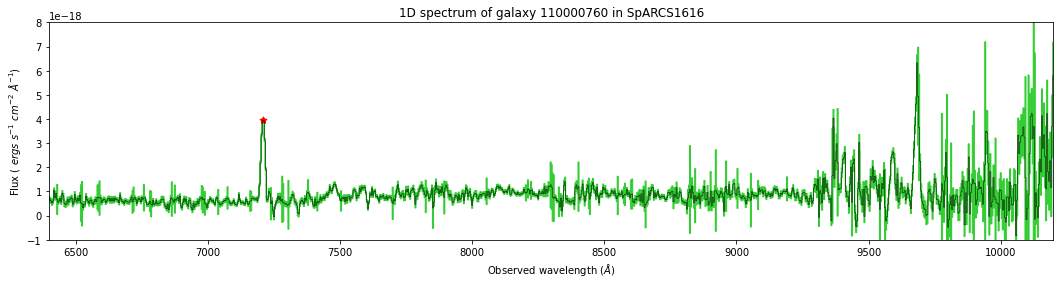

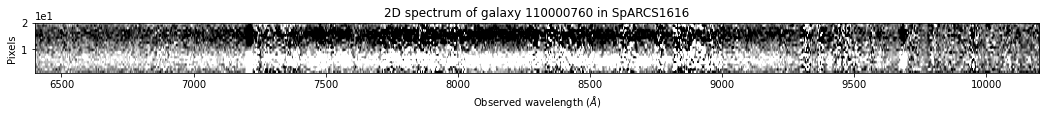

In [16]:
obj, obj_index, lam, spec, var, max_index, max_spec = display_1D(redshift_table, cluster_name, galaxy_specid)
display_2D(cluster_name, redshift_table, obj_index)

Note that distinct peaks in the 1D spectrum (excluding noise) correspond closely to distinct band signatures in the 2D spectrum, which indicate a specific element is detected. To find the redshift, [O II] is one of the emission lines of interest indicated by the red star in the 1D spectrum. In the example above, we can also spot the \[O III]4959,5007 doublet around observed wavelength 9600-9700 Angstrom. Note how there is increased spectrum noise around 9400 Angstroms and above.

<a class="anchor" id="Spec7"></a>
# Use the \[O II] emission line and a Gaussian fit of the continuum subtracted spectrum
First, zoom in a 100 Angstrom range centered around the peak of the [O II] emission line peak. Then, divide the 100 Angstrom window into three regions: [0, 25], [25,75], [75,100]. Using these three regions, find the continuum fit by finding the median value of the fit between the first and third regions.

In [17]:
xwindow_range = 50 # +/- distance from the peak of the emission line
ywindow_range = 1e-18 # not in use right now

In [18]:
def continuum_fit(lam,spec,var,max_index): 
    """
    Returns the ycontinuum and indices of [O II] emission line.

    Parameters
    ----------
    lam : numpy array of float
    Wavelength in Angstroms
    
    spec : numpy array of float
    Flux in erg cm^-2 s^-1 A^-1
    
    var : numpy array of float
    Variance of flux in erg cm^-2 s^-1 A^-1
    
    max_index : int
    Index where the peak of the [O II] emission line is

    Returns
    -------
    ycontinuum : numpy array of float
    Linear fit at +/- 25 Angstrom end regions of [O II] emission line window
    
    bounds_index : numpy array of int
    Indices for regions bounding [O II] emission line in 25 Angstrom intervals
    """
    # find the indices of the window range
    range_bounds = np.array([-xwindow_range,-25,25,xwindow_range])
    bounds_index = np.array([])
    for i in range(len(range_bounds)):
        idx = (np.abs(lam - (int(lam[max_index]) + int('%i'%range_bounds[i])) )).argmin()
        bounds_index = np.append(bounds_index,idx)
    bounds_index = bounds_index.astype(int)
    
    #set the wavelength from the indices
    region1_x = lam[bounds_index[0]:bounds_index[1]+1]
    region2_x = lam[bounds_index[2]:bounds_index[3]+1]
    region1_y = spec[bounds_index[0]:bounds_index[1]+1]
    region2_y = spec[bounds_index[2]:bounds_index[3]+1]
    print(region1_x.shape,region2_x.shape)
    
    # fit the two regions with a linear fit
    poly_region1 = (np.polyfit(region1_x, region1_y, deg=1)) # linear fit slope [0] and y-intercept [1] for region 1
    poly_region2 = (np.polyfit(region2_x, region2_y, deg=1)) # linear fit slope [0] and y-intercept [1] for region 2
    
    #take the median value of the two linear fits
    poly_median = np.median( [np.polyval(poly_region1,region1_x),np.polyval(poly_region2,region2_x)]) # median y-value from regions 1 and 2 fit
    ycontinuum = np.zeros(lam.size)
    ycontinuum[bounds_index[0]:bounds_index[3]+1] = poly_median
    
    return (ycontinuum, bounds_index)

In [19]:
def plot_emission_line(lam, spec, var, max_index, ycontinuum=np.array([]),g_fit=None):
    """
    Plots an emission line with a window range of 100 Angstroms

    Parameters
    ----------
    lam : numpy array of float
    Wavelength in Angstroms
    
    spec : numpy array of float
    Flux in erg cm^-2 s^-1 A^-1
    
    var : numpy array of float
    Variance of flux in erg cm^-2 s^-1 A^-1
    
    max_index : int
    Index where the peak of the [O II] emission line is

    ycontinuum : numpy array of float
    Linear fit at +/- 25 Angstrom end regions of [O II] emission line window
    
    g_fit : class models.Gaussian1D
    Class holding Gaussian distribution parameters from fit including amplitude, mean and std.
    
    Returns
    -------
    None
    """
    fig, ax = plt.subplots(1,1, figsize=(16,4))
    ax.step(lam, spec, color='k', where='mid', lw=0.5)
    ax.fill_between(lam, spec+np.sqrt(var), spec-np.sqrt(var), alpha=1, color='orange', step='mid')
    ax.set(title='Zoomed in 1D spectrum around [O II]', xlabel='Observed wavelength $(\AA)$', ylabel='Flux $(~ergs~s^{-1}~cm^{-2}~\AA^{-1}$)', yscale='linear', 
           xlim=[0.99*np.min(lam), np.max(lam)/0.99])
    ax.set_ylim(-1e-18,max_spec+1e-18)
    ax.set_xlim(int(lam[max_index])-xwindow_range,int(lam[max_index])+xwindow_range)
    ax.scatter(lam[max_index],spec[max_index],s=50,c='red',marker=(5, 1))
    if len(ycontinuum) != 0:
        ax.plot(lam,ycontinuum,color='b')
    elif g_fit!=None:
        x = np.linspace(int(lam[max_index])-xwindow_range,int(lam[max_index])+xwindow_range)
        y_fit = g_fit(x*u.AA)
        # print the results after the fitting is done
        print("g_fit (Fit Results): ", g_fit)
        ax.plot(x,y_fit,c='blue')
        plt.show()

(8,) (8,)


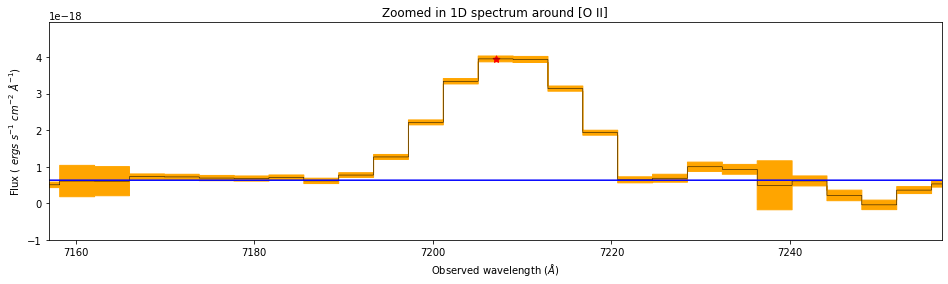

In [20]:
ycontinuum, bounds_index = continuum_fit(lam, spec, var, max_index)
plot_emission_line(lam,spec,var,max_index, ycontinuum=ycontinuum);

A Gaussian distribution is commonly known as a normal distribution and has a symmetric bell curve characterized by sigma (σ), the percentage of data under the curve in an arbitrary standard deviation away from the mean. Therefore, the spectrum should be transformed around [O II] to approximately approach zero as the spectrum goes further away from the peak of the emission line. After finding the continuum_fit as a constant, we can subtract the whole spectrum by this constant to get the continuum subtracted spectrum.

In [21]:
def subtract_spectrum(spec,max_spec,ycontinuum,max_index): 
    """
    Returns the continuum subtracted spetrum and new peak of [O II] emission line.

    Parameters
    ----------
    spec : numpy array of float
    Flux in erg cm^-2 s^-1 A^-1
    
    max_spec : float
    Flux peak of [O II] emission line
    
    ycontinuum : numpy array of float
    Linear fit at +/- 25 Angstrom end regions of [O II] emission line window
    
    max_index : int
    Index where the peak of the [O II] emission line is

    Returns
    -------
    continuum_subtracted_spectrum : numpy array of float
    Wavelength of the [O II] emission line after subtracting ycontinuum fit
    
    newmax_spec : float
    New flux peak of [O II] emission line
    """
    # subtract continuum and plot new spectrum
    continuum_subtracted_spectrum = spec - ycontinuum
    newmax_spec = max_spec - ycontinuum[max_index]
    
    return (continuum_subtracted_spectrum, newmax_spec)

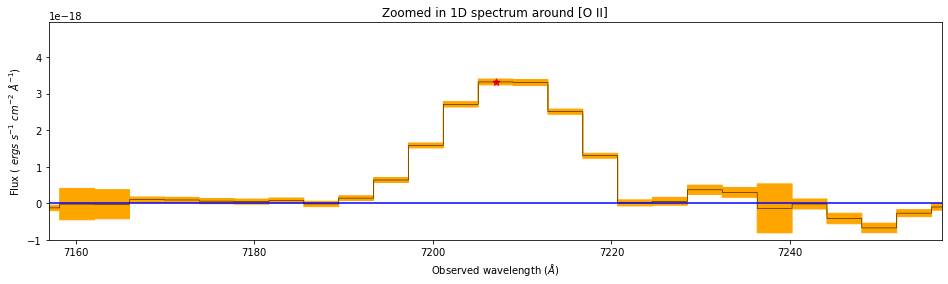

In [22]:
continuum_subtracted_spectrum, newmax_spec = subtract_spectrum(spec, max_spec, ycontinuum, max_index)
plot_emission_line(lam,continuum_subtracted_spectrum,var,max_index, ycontinuum=np.zeros(len(continuum_subtracted_spectrum)));

The continuum subtracted spectrum around emission line [O II] roughly goes to zero in both the positive and negative direction from the plotted window. Now, fit a Gaussian distribution of [O II].

In [23]:
def emission_gaussian(lam, continuum_subtracted_spectrum, bounds_index, var, max_index):
    """
    Returns the Gaussian fit of the continuum subtracted spetrum [O II] emission line.

    Parameters
    ----------
    lam : numpy array of float
    Wavelength in Angstroms
    
    continuum_subtracted_spectrum : numpy array of float
    Wavelength of the [O II] emission line after subtracting ycontinuum fit
    
    bounds_index : numpy array of int
    Indices for regions bounding [O II] emission line in 25 Angstrom intervals
    
    var : numpy array of float
    Variance of flux in erg cm^-2 s^-1 A^-1
    
    max_index : int
    Index where the peak of the [O II] emission line is

    Returns
    -------
    g_fit : class models.Gaussian1D
    Gaussian fit parameters of the [O II] emission line including amplitude, mean and std
    """
    # these units are for reference
    flux_units = u.erg/u.s/(u.cm**2)/u.AA
    spec_units = u.erg/u.s/(u.cm**2)

    # find and plot gaussian fit
    sub_region = SpectralRegion((int(lam[max_index])-xwindow_range)*u.AA,(int(lam[max_index])+xwindow_range)*u.AA)
    print(sub_region)
    # use the wavelength and flux to create a Spectrum1D object
    spectrum = Spectrum1D(spectral_axis=lam*u.AA, flux=continuum_subtracted_spectrum*flux_units)
    sub_spectrum = extract_region(spectrum, sub_region)
    
    # Initialize Gaussian model with estimates of amplitude, mean, stddev 
    g_init = models.Gaussian1D(newmax_spec, lam[max_index], 5.)
    g_fit = fit_lines(spectrum, g_init)
    # print initial guess values
    print("g_init (Initial Guesses): ", g_init)

    return g_fit

Spectral Region, 1 sub-regions:
  (7157.0 Angstrom, 7257.0 Angstrom) 

g_init (Initial Guesses):  Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          amplitude             mean      stddev
    --------------------- --------------- ------
    3.318792716549051e-18 7207.0334379673    5.0
g_fit (Fit Results):  Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          amplitude              mean             stddev     
    erg / (Angstrom cm2 s)     Angstrom          Angstrom    
    ---------------------- ---------------- -----------------
     3.535571123962053e-18 7208.42112356152 7.034589845909856


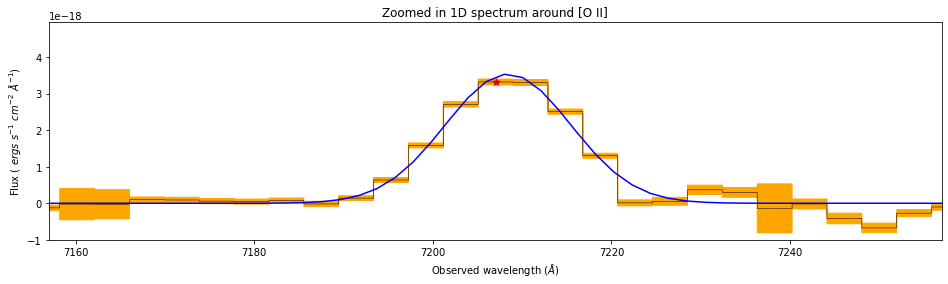

In [24]:
g_fit = emission_gaussian(lam, continuum_subtracted_spectrum, bounds_index, var, max_index)
plot_emission_line(lam,continuum_subtracted_spectrum,var,max_index, g_fit=g_fit);

The Gaussian fit for emission line [O II] has three important parameters: amplitude, mean and standard deviation. Use these values to find an estimate redshift and [O II] equivalent width, and compare the estimates to the numbers pulled from the dataset.

<a class="anchor" id="Spec8"></a>
# Compare calculated to GOGREEN redshift and EW values

In [25]:
def gaussian_equation(amplitude,mean,std):
    """
    Returns the probability density function of a Gaussian distribution

    Parameters
    ----------
    amplitude : float
    Peak flux of the Gaussian distribution
    
    mean : float
    Wavelength where the peak flux of the Gaussian Distribution is
    
    std : float
    How wide the Gaussian distribution is

    Returns
    -------
    lambda x : float
    Probability density function of Gaussian distribution at a specific wavelength (x)
    """
    return lambda x: amplitude*(np.exp(-1/2*((x-mean)/std)**2))

def calculate_values(g_fit,lam,max_index,obj,clusters_table,cluster_name,galaxy_specid):
    """
    Returns the estimated redshift and equivalent width of [O II] emission line and compares them with the dataset.

    Parameters
    ----------
    g_fit : class models.Gaussian1D
    Gaussian fit parameters of the [O II] emission line including amplitude, mean and std
    
    lam : numpy array of float
    Wavelength in Angstroms
    
    max_index : int
    Index where the peak of the [O II] emission line is

    obj : pandas dataframe
    Data table pulled from redshift_table of selected galaxy
    
    clusters_table : pandas dataframe
    Data table for all clusters
    
    cluster_name : string
    Name of the selected cluster
    
    galaxy_specid : int
    Number to identify specific galaxy
    
    Returns
    -------
    None
    """
    obs_wave = g_fit.mean.value #*u.AA
    std = g_fit.stddev.value #*u.AA
    amplitude = g_fit.amplitude.value #*flux_units
    rest_wave = 3727 #*u.AA #value from Google for O II
    redshift_z = (obs_wave/rest_wave)-1 #unitless
    
    line_flux = integrate.quad(gaussian_equation(amplitude,obs_wave,std),(int(lam[max_index])-xwindow_range),(int(lam[max_index])+xwindow_range)) #*spec_units
    
    integral_gauss = amplitude*std*np.sqrt(2*np.pi) # another way to find integral of gaussian
    
    # to find the EW of [O II], the formula is area of flux / max flux of [O II] / (1 + redshift),
    #where the (1 + redshift) is to change to the observed frame
    line_ew = line_flux[0]/ycontinuum[max_index]/(1+redshift_z)
    line_ew2 = integral_gauss/ycontinuum[max_index]/(1+redshift_z)
    
    display_html(obj)
    
    redshift_difference = clusters_table.redshift[index_num]-obj.redshift[np.nanmin(obj.index)] # difference between galaxy and cluster
    light_speed= 3e5 # km/s
    velocity_difference = (redshift_difference) * light_speed # km/s
    
    percent_err_redshift = ((redshift_z - obj.redshift[np.nanmin(obj.index)]) / obj.redshift[np.nanmin(obj.index)]) * 100
    percent_err_ew = ((line_ew - obj.ewoii[np.nanmin(obj.index)]) / obj.ewoii[np.nanmin(obj.index)]) * 100
    percent_err_ew_model = ((line_ew - obj.ewoii_model[np.nanmin(obj.index)]) / obj.ewoii_model[np.nanmin(obj.index)]) * 100

    print("Flux value and value_error =",line_flux)
    print("Calculated redshift = %f, EW by integrate.quad() = %f, EW by amplitude*std*np.sqrt(2*np.pi) = %f" %(redshift_z,line_ew,line_ew2))
    print("\nDifference between calculated redshift and GOGREEN = %f, percent error = %.2f" %(abs(redshift_z - obj.redshift[np.nanmin(obj.index)]),percent_err_redshift) + '%')
    print("Difference between calculated EW and GOGREEN = %f, percent error = %.2f" %(abs(line_ew-obj.ewoii[np.nanmin(obj.index)]),percent_err_ew) + '%.')
    print("Difference between calculated EW-model and GOGREEN = %f, percent error = %.2f" %(abs(line_ew-obj.ewoii_model[np.nanmin(obj.index)]),percent_err_ew_model) + '%')
    print("\nThe difference between the galaxy redshift and the redshift of the cluster is %f\n\
which corresponds to a velocity difference of %.2f km/s.\n\
For reference, the typical threshold for a cluster membership is a velocity difference under 1,500 km/s.\n\
Based on this, galaxy with spec id %i is probably not a member of cluster %s.\n\
Checking the redshift_table, the membership flag is %i." %(redshift_difference, velocity_difference, \
                                                           galaxy_specid,cluster_name,obj.member[np.nanmin(obj.index)]))

In [26]:
calculate_values(g_fit, lam, max_index, obj, clusters_table, cluster_name, galaxy_specid)

,cluster,specid,ra,dec,objclass,redshift,redshift_quality,extver,spec_flag,snr_8500_var,snr_8500_rms,d4000,ed4000,ewoii,eewoii,ewhdelta,eewhdelta,ewoii_model,eewoii_model,f_oii,ef_oii,sfr_oii,esfr_oii,delta_bic,member_clean,member_em,member,htm9,ring256,nest4096,random_id
1458,SpARCS1616,110000760,244.19926,55.714027,1,0.93372,4,1,0,7.455099,4.035182,1.164522,0.040819,0.0,0.0,0.0,0.0,50.33022,1.101667,0.0,0.0,2.362466,0.03426,6381.294,0,0,0,3515739,67843,41608456,6.687962


Flux value and value_error = (6.234308557875552e-17, 1.7476529618610082e-22)
Calculated redshift = 0.934108, EW by integrate.quad() = 51.091709, EW by amplitude*std*np.sqrt(2*np.pi) = 51.091709

Difference between calculated redshift and GOGREEN = 0.000388, percent error = 0.04%
Difference between calculated EW and GOGREEN = 51.091709, percent error = inf%.
Difference between calculated EW-model and GOGREEN = 0.761489, percent error = 1.51%

The difference between the galaxy redshift and the redshift of the cluster is 0.222280
which corresponds to a velocity difference of 66684.00 km/s.
For reference, the typical threshold for a cluster membership is a velocity difference under 1,500 km/s.
Based on this, galaxy with spec id 110000760 is probably not a member of cluster SpARCS1616.
Checking the redshift_table, the membership flag is 0.


### Note:
If the [O II] equivalent width (ewoii) is 0 and results in a percent error of infinity, this means there is an error from the database (known issue for GOGREEN DR1, which has been fixed for the upcoming GOGREEN DR2). Therefore, use the ewoii_model to compare the estimated equivalent width to the number in the database.

Overall, to recap, the cluster and galaxy dataset tables were read from GOGREEN DR1. Then, we utilized the SIA service to search for the processed image urls of our pre-selected galaxy in a cluster. The condition for the selected galaxy is that there is a .fits file in both the 1D and 2D spectrum directories. After plotting the galaxy image, we opened the .fits file using BytesIO to retrieve and convert the wavelength, flux, and variance of flux into the appropriate units. The 1D and 2D spectra show emissions lines useful to extract the galaxy's redshift, emission line equivalent widths, galaxy type, and other information. The [O II] emission line was estimated to be around 7000 to 7500 Angstroms, so we zoomed in a 100 Angstrom window around the highest emission line peak in that area. Finally, we compute a continuum subtracted spectrum, and a Gaussian1D fit to the [O II] emission line determined the amplitude, mean and standard deviation of the distribution. These three numbers are used to determine the galaxy's redshift and [O II] equivalent width, which is quite close to the GOGREEN database with a difference below five percent.

<a class="anchor" id="Spec9"></a>
# References

Notebook [Listing files in the GOGREEN DR1 Dataset](https://github.com/astro-datalab/notebooks-latest/blob/master/03_ScienceExamples/GOGREEN_GalaxiesInRichEnvironments/0_GOGREENDr1FileService.ipynb)

Notebook [GOGREEN Data Release 1 data access at Astro Data Lab](https://github.com/astro-datalab/notebooks-latest/blob/master/03_ScienceExamples/GOGREEN_GalaxiesInRichEnvironments/1_GOGREENDr1DataAccessAtDataLab.ipynb)

Notebook [GOGREEN DR1 at Data Lab - Simple Image Access (SIA)](https://github.com/astro-datalab/notebooks-latest/blob/master/03_ScienceExamples/GOGREEN_GalaxiesInRichEnvironments/2_GOGREENDr1SIA.ipynb)

[Balogh et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021MNRAS.500..358B/abstract) "The GOGREEN and GCLASS surveys: first data release." MNRAS 500, 358